# Sklearn Pipeline for Scoring New Data

In [1]:
%matplotlib inline
from joblib import dump, load
import pandas as pd
import pylab
import numpy as np
import seaborn as sns
from feature_engine.encoding import RareLabelEncoder
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import linear_model
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import gower
from sklearn.ensemble import RandomForestClassifier
import shap

c:\Users\Sebas\anaconda3\envs\aws_sagemaker\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import Data
the dataset is available here: https://archive.ics.uci.edu/ml/datasets/adult

In [2]:
# load the local dataset 
df = pd.read_csv('../data/adult_dataset.csv')

In [3]:
df.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
# Relabel taget colum since there is no target in unsupervised learning
df.rename(columns={"Target": "Income"}, inplace=True)

# Correct the Income column typo
df['Income'] = df['Income'].apply(lambda x: x.replace('.', ''))

# Load Model Artifacts

In [5]:
categorical_imputer = load('../artifacts/categorical_imputer.joblib') # trained model to impute missing categorical data
numeric_imputer = load('../artifacts/numeric_imputer.joblib') # trained model to impute missing numeric data
rare_encoder = load('../artifacts/rare_encoder.joblib') # trained model to encode rare labels
capper = load('../artifacts/capper.joblib') # trained model to cap outliers
enc = load('../artifacts/enc.joblib') # trained one hot encoder
model = load('../artifacts/model.joblib') # trained random forrest classifier

# Transform Dataset

In [6]:
# get numeric and categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = df.select_dtypes(include=numerics).columns.to_list()
categorical_columns = df.select_dtypes(exclude=numerics).columns.to_list()

In [7]:
# impute mising numeric features
df_numeric = pd.DataFrame(
    numeric_imputer.transform(df[numeric_columns]), 
    columns=numeric_columns, 
    index=df.index)

# impute mising categorical features
df_categorical = pd.DataFrame(
    categorical_imputer.transform(df[categorical_columns]), 
    columns=categorical_columns, 
    index=df.index)

# concate numeric and categorical features
df = pd.concat([df_numeric, df_categorical], axis=1)

# remove rare labels
df[categorical_columns] = rare_encoder.transform(df[categorical_columns])

# remove outliers
df[numeric_columns] = capper.transform(df[numeric_columns])

# one hot encoding categorical features
df_cat_hotenc = pd.DataFrame(
    enc.transform(df[categorical_columns]), 
    columns=enc.get_feature_names_out(),
    index=df.index) 

# concate numeric and hot-encoded categorical features
df_hotenc = pd.concat([df[numeric_columns], df_cat_hotenc], axis=1)

# predict cluster
labels = model.predict(df_hotenc)

# add cluster label to df
df['cluster'] = labels

df.head()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income,cluster
0,39.0,77516.0,13.0,2174.0,0.0,40.0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K,0
1,50.0,83311.0,13.0,0.0,0.0,13.0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K,0
2,38.0,215646.0,9.0,0.0,0.0,40.0,Private,HS-grad,Divorced,Rare,Not-in-family,White,Male,United-States,<=50K,2
3,53.0,234721.0,7.0,0.0,0.0,40.0,Private,Rare,Married-civ-spouse,Rare,Husband,Black,Male,United-States,<=50K,0
4,28.0,338409.0,13.0,0.0,0.0,40.0,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Rare,<=50K,0


# Data Visualization

In [8]:
np.sort(df['cluster'].unique())

array([0, 1, 2, 3], dtype=int64)

<AxesSubplot: xlabel='cluster', ylabel='Count'>

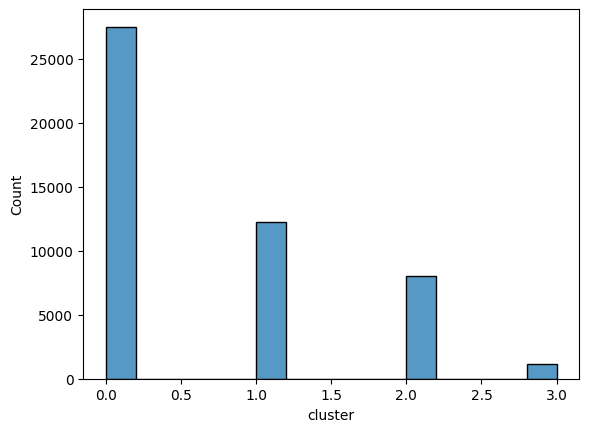

In [9]:
sns.histplot(
    data=df, 
    x='cluster',
    bins=15
)

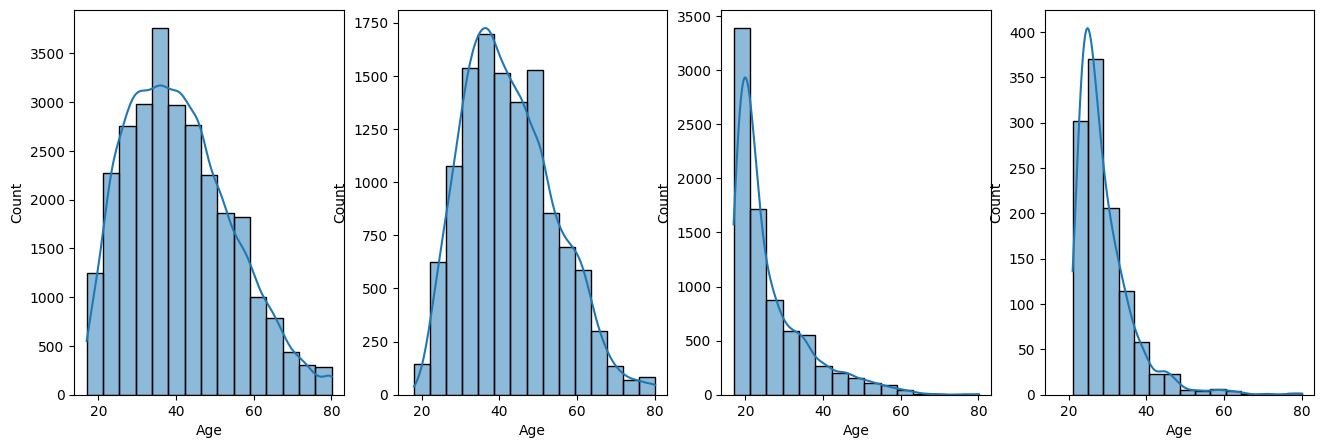

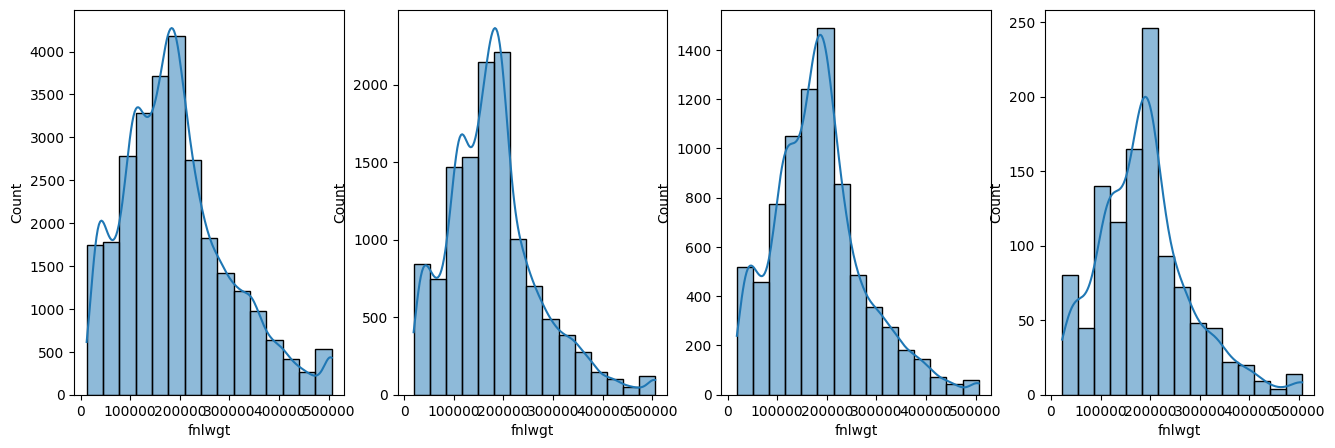

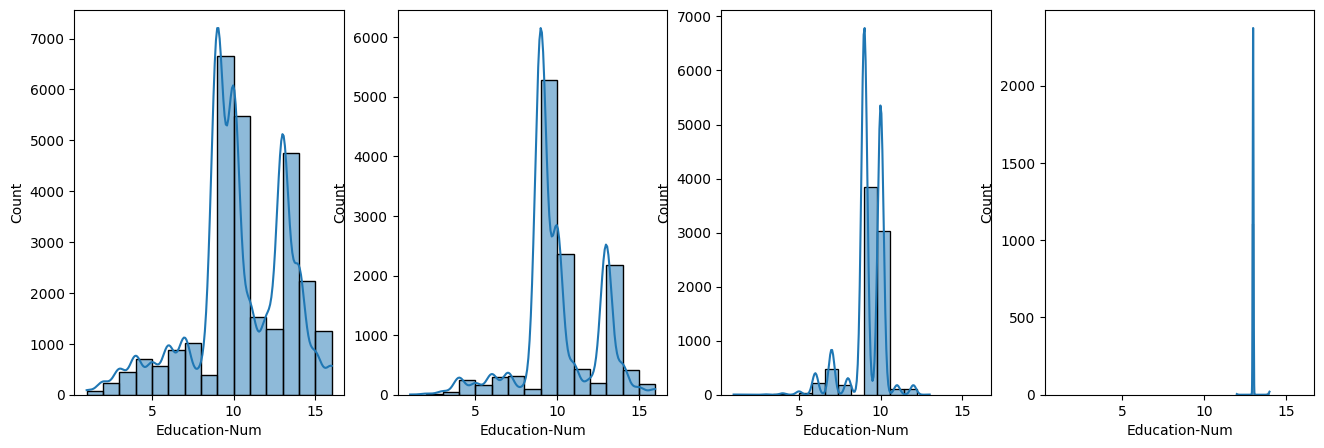

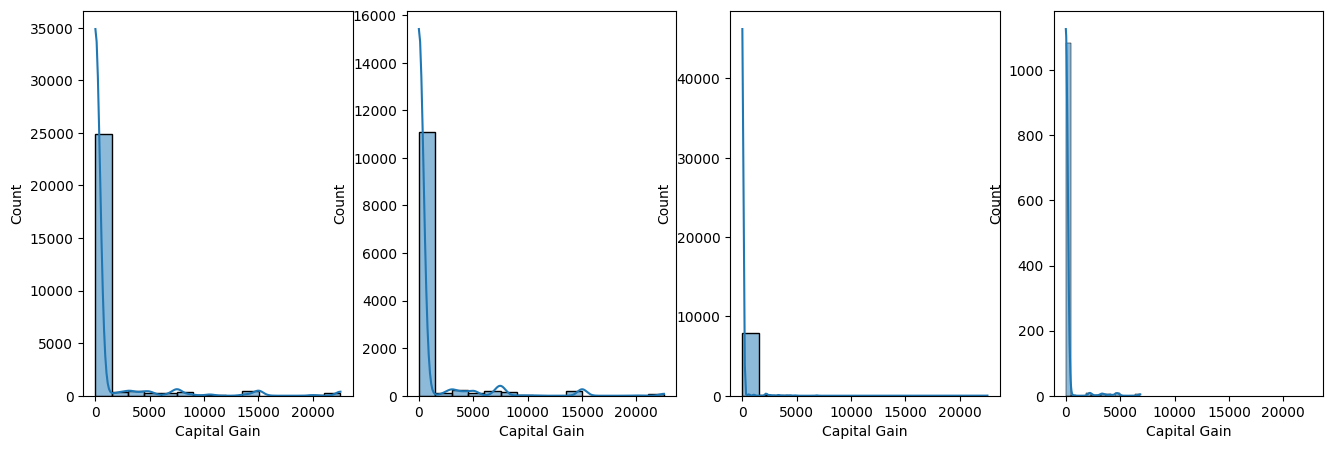

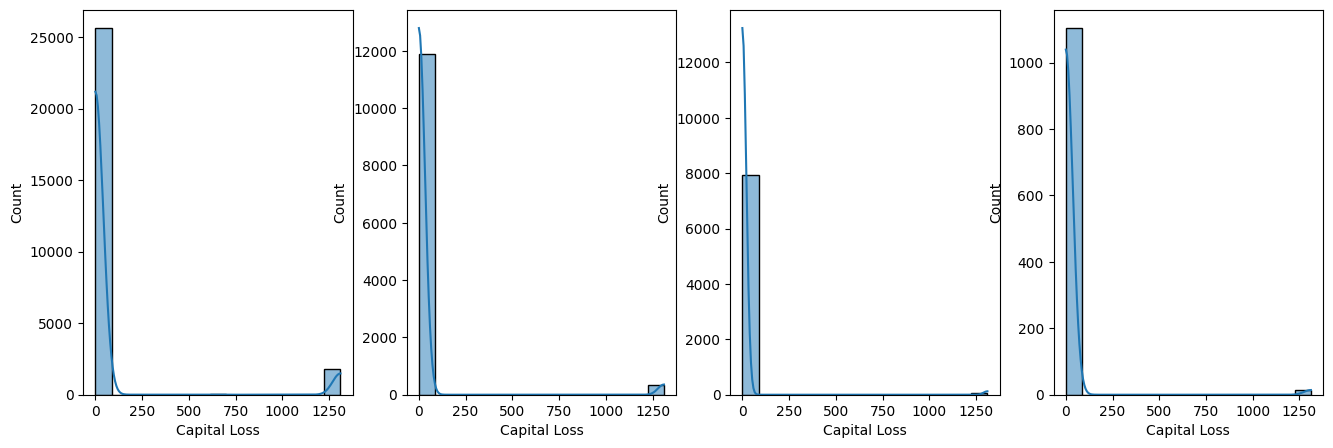

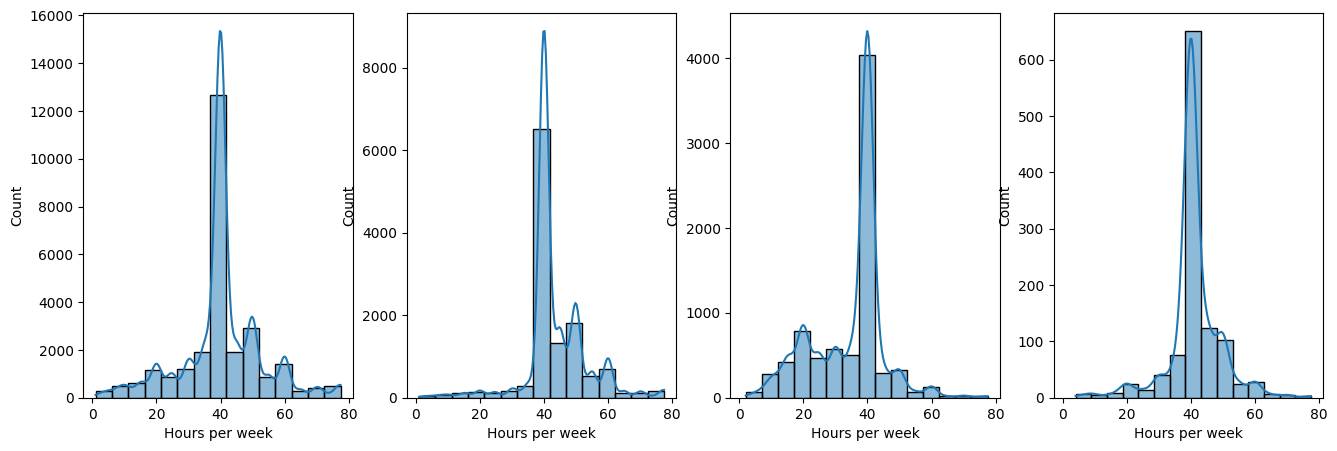

In [10]:
# visualize numeric features for each cluster
for feat in numeric_columns:

    fig, ax = plt.subplots(
        figsize=(16,5), 
        nrows=1, ncols=df['cluster'].nunique(), 
        sharex=True)
    
    for c in np.sort(df['cluster'].unique()):

        sns.histplot(
            data=df[df['cluster']==c], 
            x=feat,
            bins=15,
            kde=True,
            ax=ax[c])
    plt.show()

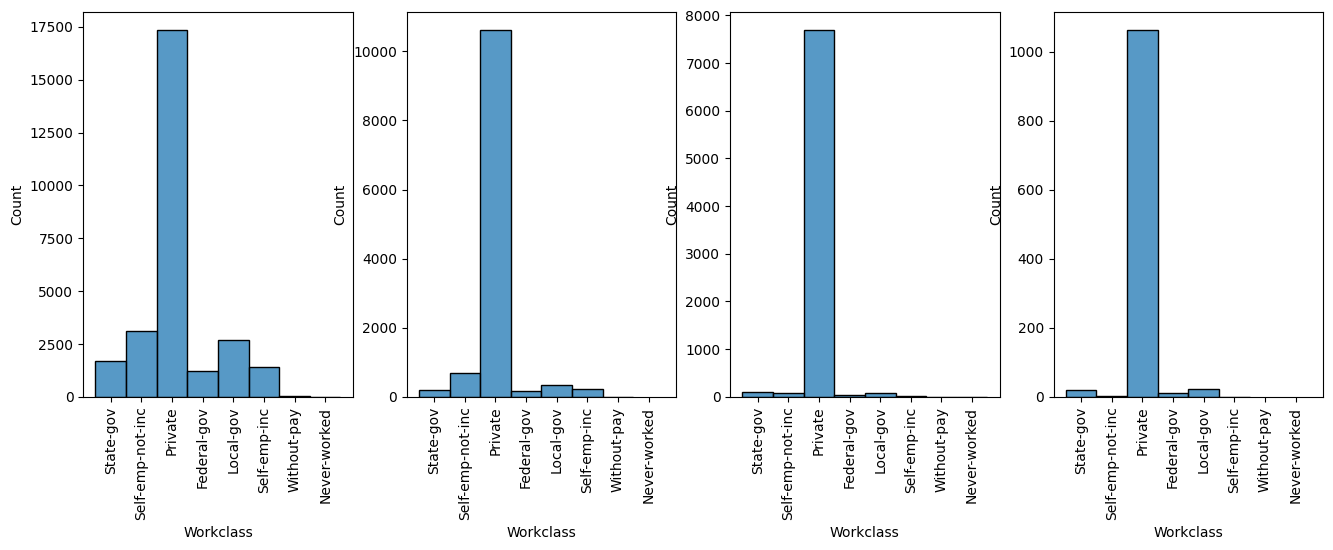

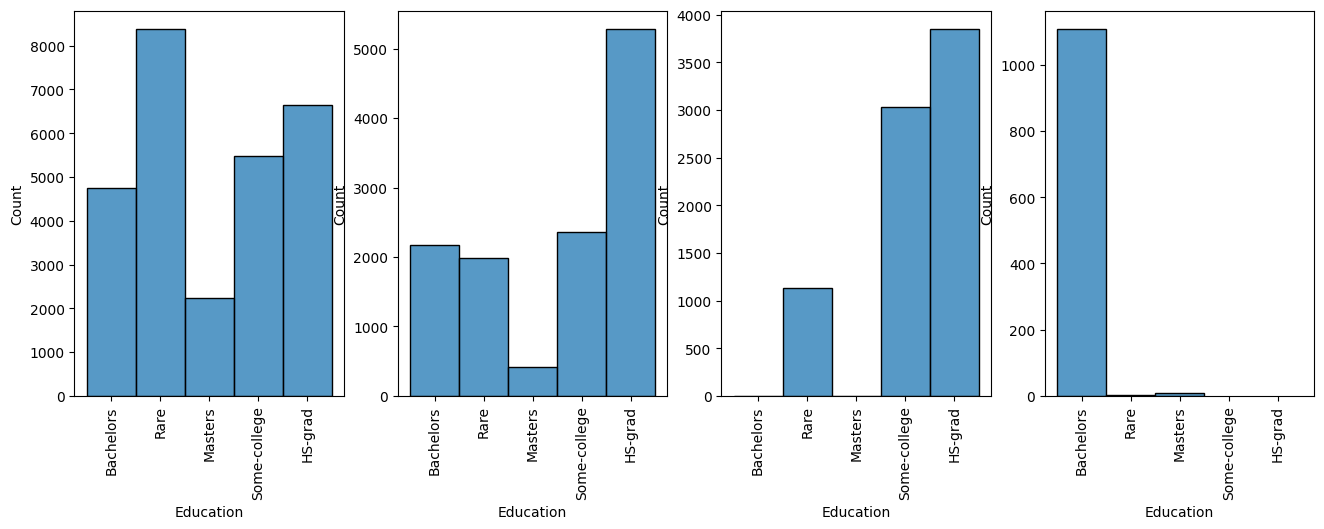

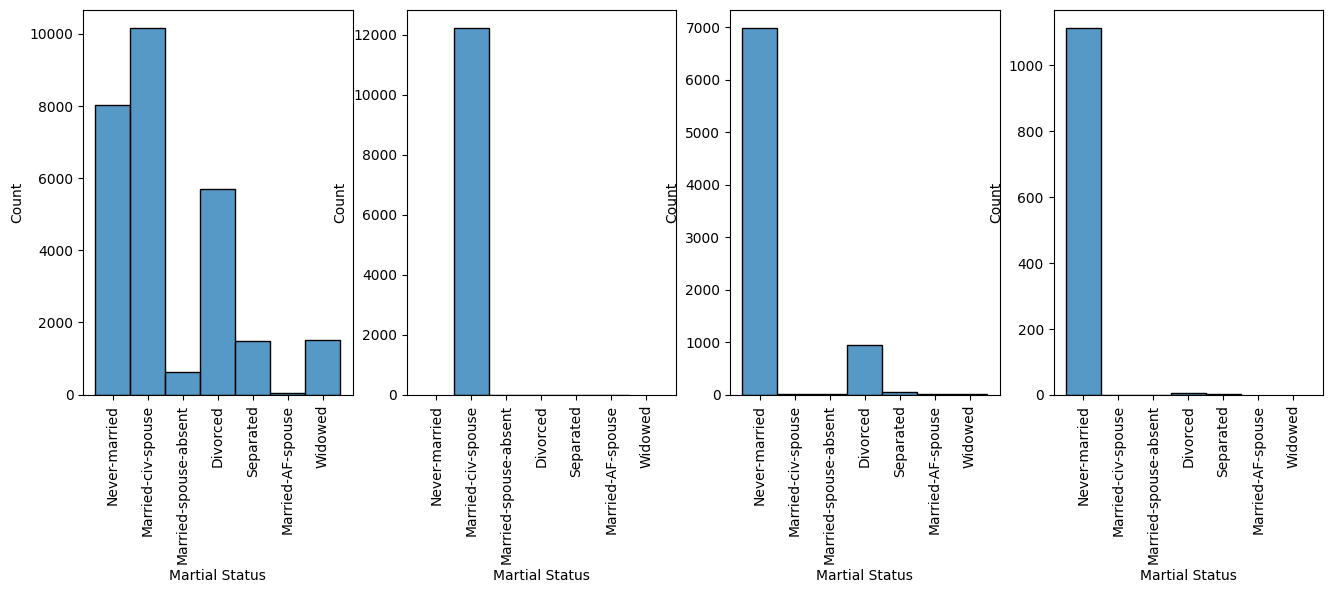

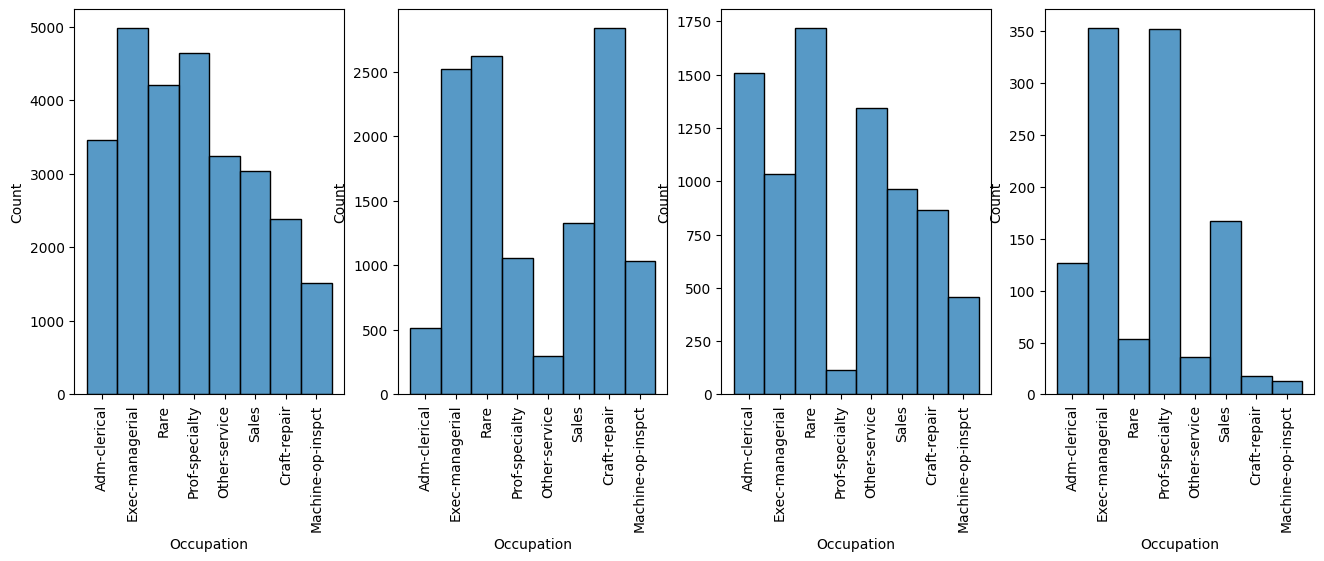

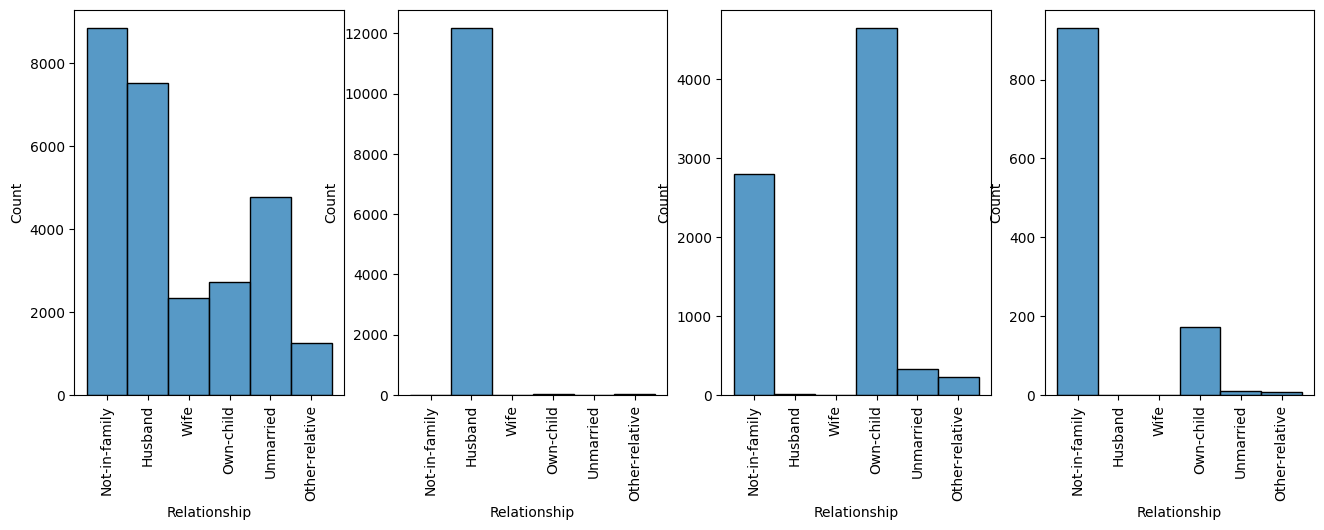

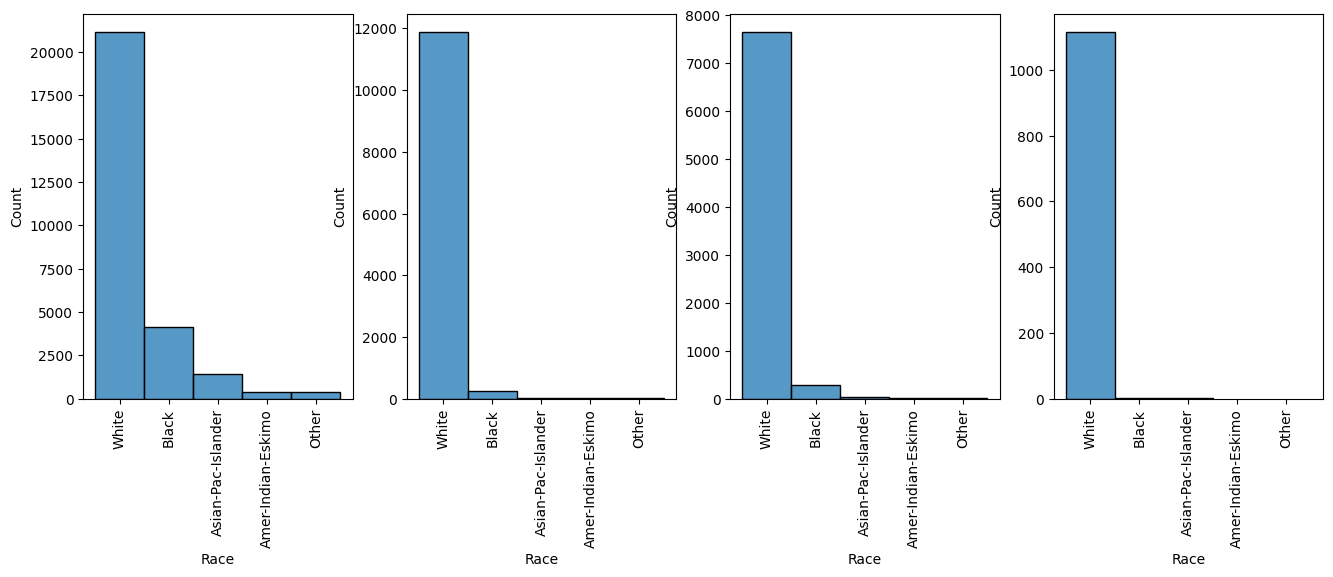

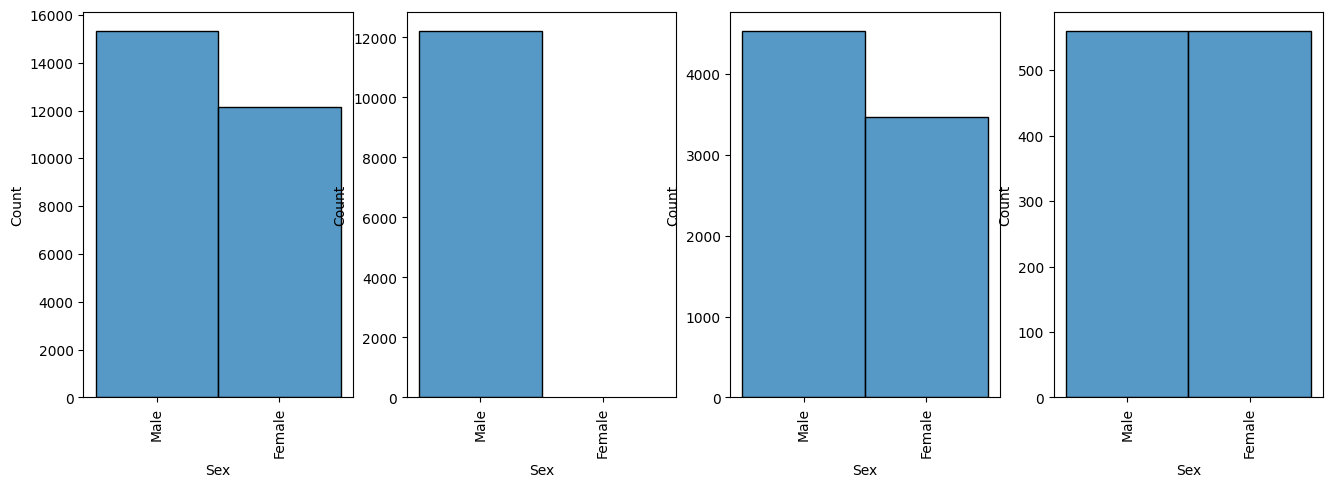

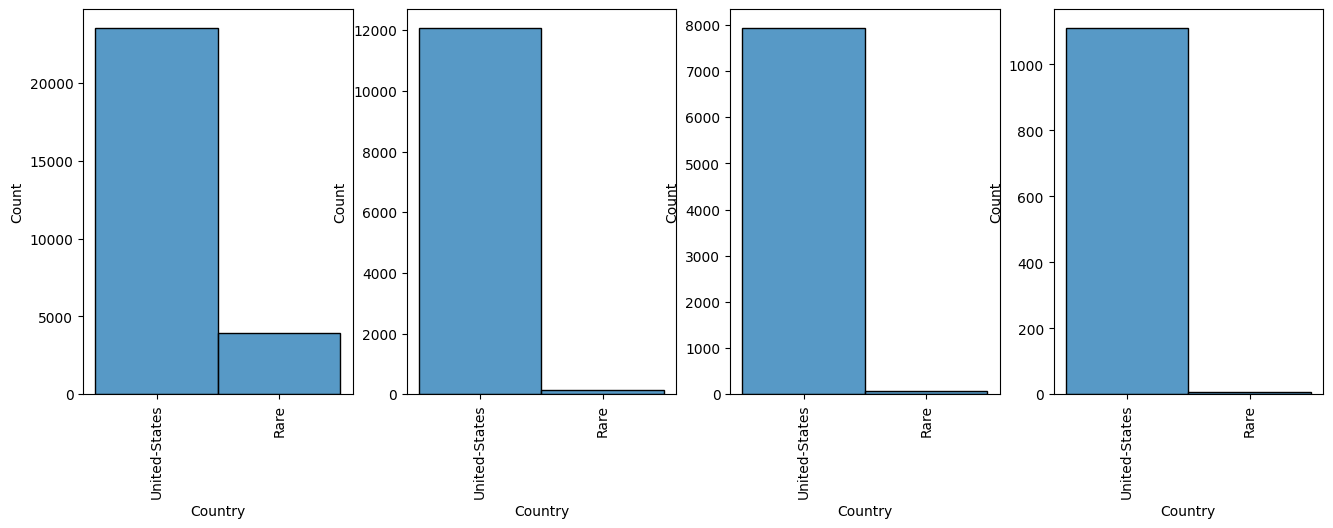

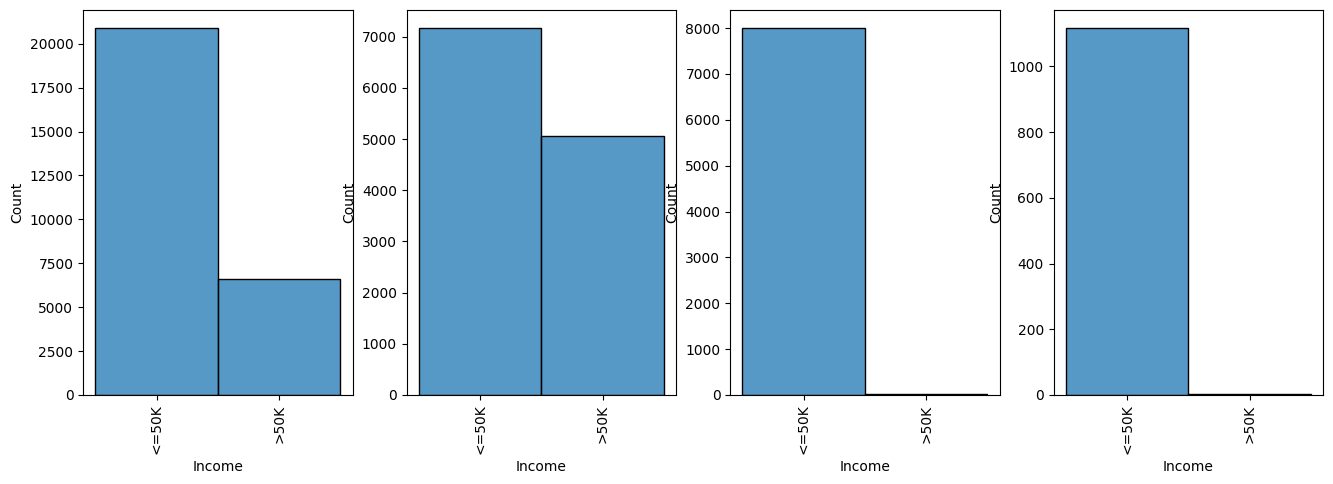

In [11]:
# visualize categorical features for each cluster
for feat in categorical_columns:

    fig, ax = plt.subplots(
        figsize=(16,5), 
        nrows=1, ncols=df['cluster'].nunique(), 
        sharex=True)
    
    for c in np.sort(df['cluster'].unique()):

        sns.histplot(
            data=df[df['cluster']==c], 
            x=feat,
            ax=ax[c])
        ax[c].set_xticks(ax[c].get_xticks(), ax[c].get_xticklabels(), rotation=90)
        
    plt.show()

# Explain Clusters

In [75]:
# Tree Explainer
explainer = shap.TreeExplainer(
    model = model.best_estimator_,
    data = df_hotenc.sample(10),
    feature_perturbation = "interventional", 
    output = "probability")

In [76]:
shap_values = explainer.shap_values(df_hotenc)

100%|===================| 195168/195368 [14:28<00:00]        

In [92]:
# Kernel Explainer
kernel_explainer = shap.KernelExplainer(
    model = model.best_estimator_.predict_proba,
    data = df_hotenc.sample(1000)
)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [93]:
shap_values = kernel_explainer.shap_values(
    df_hotenc.sample(1000), 
    nsamples='auto')

  0%|          | 0/1000 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC

KeyboardInterrupt: 

In [87]:
shap_values

[array([[ 0.        ,  0.0762113 ,  0.01568936, ...,  0.10370477,
          0.41782642,  0.        ],
        [ 0.03630544,  0.        ,  0.0416015 , ..., -0.03694879,
          0.25143947,  0.        ],
        [ 0.02269587,  0.05426442,  0.        , ...,  0.12173978,
         -0.04313673,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -0.02914416,
          0.27873334,  0.03434803],
        [ 0.        ,  0.        ,  0.04073414, ..., -0.14799993,
         -0.04571751, -0.03695922],
        [ 0.        ,  0.06958597, -0.10059563, ..., -0.09062483,
         -0.01025547,  0.        ]]),
 array([[ 0.        , -0.00859142, -0.01854496, ..., -0.10433963,
         -0.0592677 ,  0.        ],
        [-0.0268317 ,  0.        , -0.0052553 , ...,  0.03907156,
         -0.19860533,  0.        ],
        [ 0.00025934, -0.01085579,  0.        , ..., -0.1127455 ,
          0.        ,  0.        ],
        ...,
        [ 0.00494523,  0.01142591,  0.        , ...,  

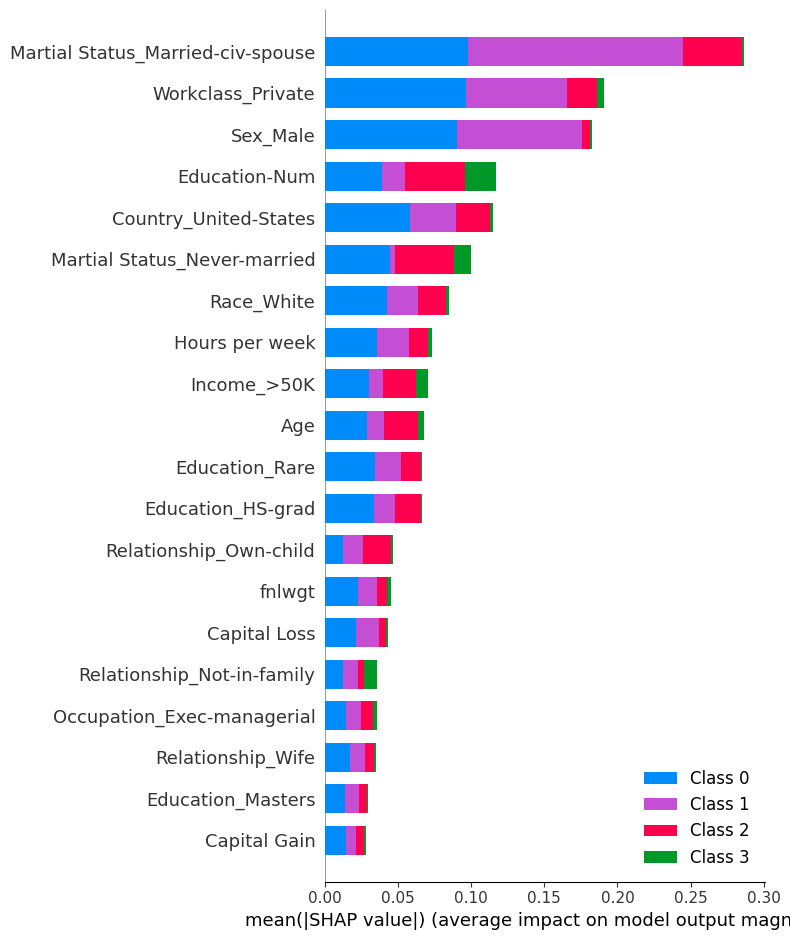

In [88]:
shap.summary_plot(shap_values, df_hotenc)

# Explain Single Class Decision

In [89]:
shap_values[0].shape

(100, 42)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


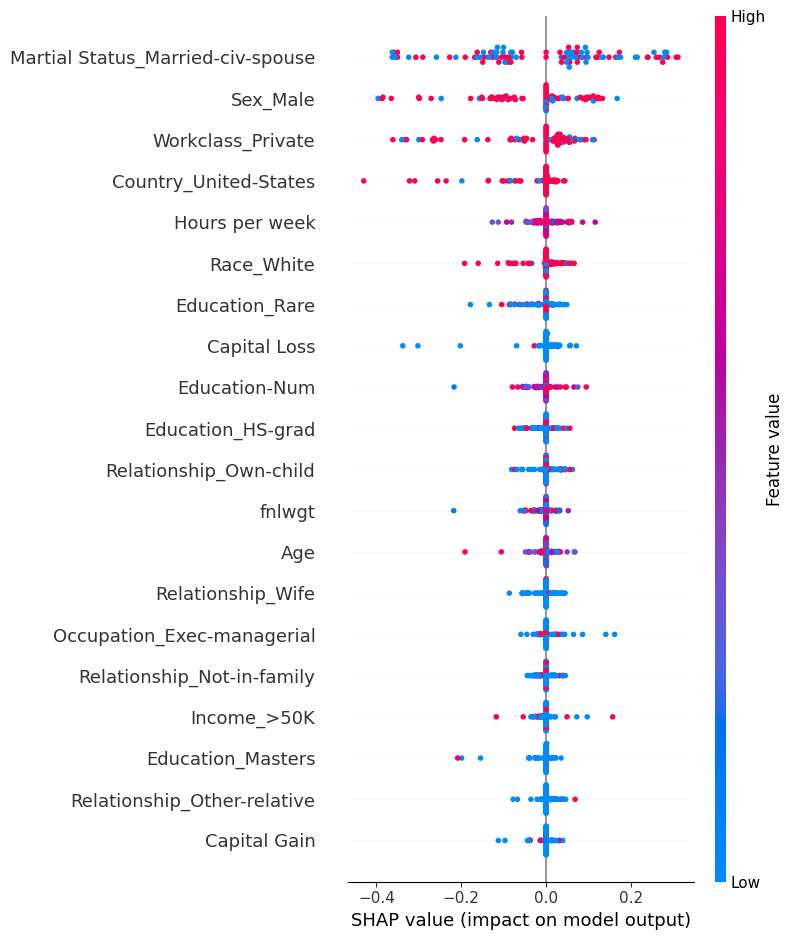

In [91]:
shap.summary_plot(shap_values[1], df_hotenc.sample(100))